In [1]:
import numpy as np
import cv2
from PIL import Image
import open3d as o3d

import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib import rcParams
from shapely.geometry import MultiPoint, box

# from pyquaternion.quaternion import Quaternion
from pyquaternion import Quaternion
import os.path as osp
from nuscenes import NuScenes

# Utils for Lidar and Radar
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.geometry_utils import view_points, BoxVisibility
from nuscenes.utils.data_classes import LidarPointCloud
from nuscenes.utils.data_classes import RadarPointCloud
from nuscenes.scripts.export_2d_annotations_as_json import get_2d_boxes, post_process_coords
from utils import *

from typing import Tuple, List, Dict, Union

%matplotlib inline

In [2]:
#nusc = NuScenes(version='v1.0-mini', dataroot='/home/gus/Documents/AI_S/nuScenes/v1_0-mini', verbose=True)
nusc = NuScenes(version='v1.0-mini', dataroot='/home/sherlock/Documents/nuScenes/data', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.5 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


## Example usage

Obtaining a single sample out of the dataset, sampling the first annotation from that sample and renderization.

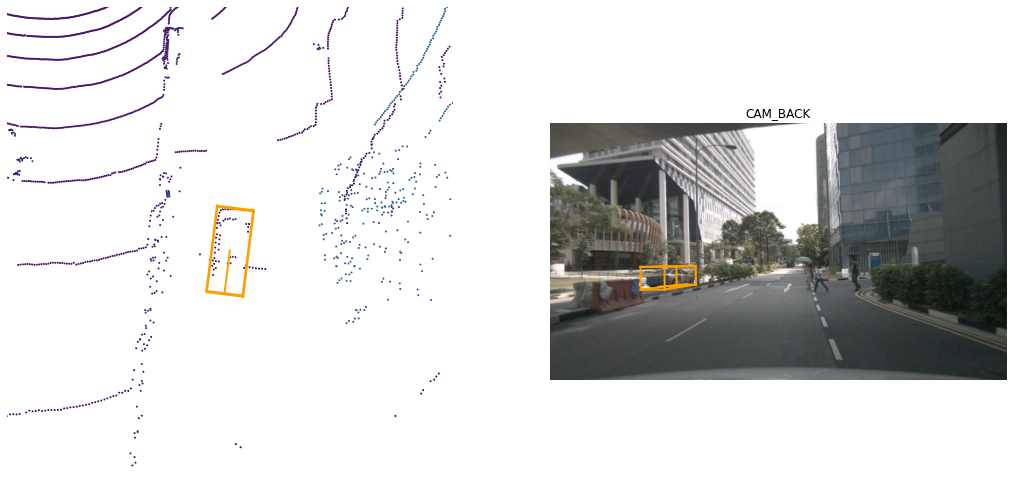

In [67]:
my_sample = nusc.sample[0]
annotation_token = my_sample['anns'][7] #11
my_annotation_metadata =  nusc.get('sample_annotation', annotation_token)
nusc.render_annotation(annotation_token)

Obtaining the camera channel used to obtain the previously annotated object.

In [68]:
camera_channel = get_camera_data(nusc, my_annotation_metadata['token'])
camera_channel

'CAM_BACK'

Computing the 2D bounding box out of an instance, camera's sample data, and used channel.

In [69]:
sensor_laser = 'LIDAR_TOP'
# Sample data from ca Sensor
cam_data = nusc.get('sample_data', my_sample['data'][camera_channel])
# Sample data from point Sensor
point_data = nusc.get('sample_data', my_sample['data'][sensor_laser])

# Obtaining box
new_box = target_to_cam(nusc, point_data['token'], annotation_token, pointsensor_channel = sensor_laser)
new_box

label: nan, score: nan, xyz: [9.15, -19.54, -1.65], wlh: [1.84, 4.32, 1.63], rot axis: [-0.01, -0.02, 1.00], ang(degrees): -97.12, ang(rad): -1.70, vel: nan, nan, nan, name: vehicle.car, token: 63b89fe17f3e41ecbe28337e0e35db8e

label: nan, score: nan, xyz: [-1.35, -14.91, -1.34], wlh: [1.02, 0.92, 1.67], rot axis: [-0.66, -0.30, 0.69], ang(degrees): -3.03, ang(rad): -0.05, vel: nan, nan, nan, name: human.pedestrian.adult, token: 02248ff567e3497c957c369dc9a1bd5c

Computing the 2D bounding box out of the interest instance

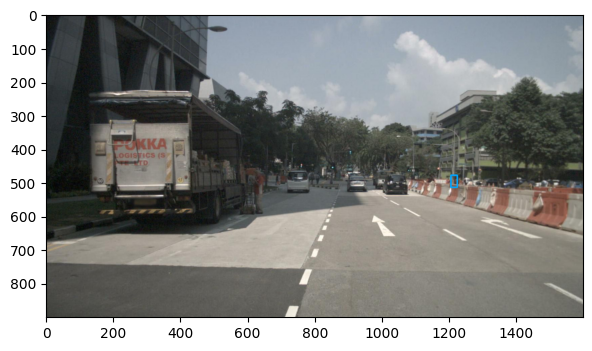

(1206.5693751819115, 477.86111828160216, 1225.8893058022243, 513.6450176828284)

In [6]:
coords = bbox_3d_to_2d(nusc, camera_token = cam_data['token'], annotation_token = annotation_token, 
                       visualize = True)
coords

Computing the point cloud of the interest instance.

The shape of the points in the image are: (3, 3)
The shape of the depths in the image are: (3,)
The shape of the original points in the camera frame are: (3, 3)


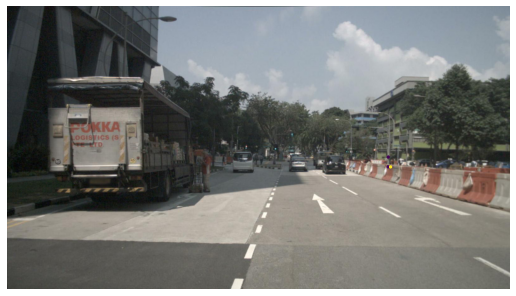

In [7]:
# Method to map a point cloud to a particular bounding box
points, coloring, ori_points, im = map_pointcloud_to_image_(nusc, coords, point_data['token'], 
                                                            cam_data['token'], visualize = True)
# Points in current image frame
print('The shape of the points in the image are: {}'.format(points.shape))
# Depths of the points in the image frame
print('The shape of the depths in the image are: {}'.format(coloring.shape))
# Filtered points in camera coordinates
print('The shape of the original points in the camera frame are: {}'.format(ori_points.shape))

## Loop to obtain all the interest objects of the dataset

The next loop will sample all the annotations of interest from the dataset and save them in the desired path.

In [70]:
# Point sensor which will be used by default
sensor_laser = 'LIDAR_TOP'

# Number of samples which will be used to loop
n_samples = np.array(nusc.sample).shape

# Folder for Pointcloud, NOTE: you have to create the folders!

#pc_folder = '/home/gus/Documents/AI_S/ML/PF/anno_pc/'
pc_folder = '/home/sherlock/Documents/3d_obj_detection/points/'

#sample_folder = '/home/gus/Documents/AI_S/ML/PF/sample_file/'
sample_folder = '/home/sherlock/Documents/3d_obj_detection/anns/'

for sample_idx in range(n_samples[0]):
    
    # Obtain current sample
    current_sample = nusc.sample[sample_idx]
    
    # Sample data from Laser Sensor
    point_data = nusc.get('sample_data', current_sample['data'][sensor_laser])
    
    # Obtaining all the tokens of the annotations in the current sample
    annotations = current_sample['anns']
    
    # Create dictionary to store all the annotation info in JSON for each sample
    data_json = {}
    data_json['instance'] = []
    
    # Loop over all the annotations
    for ann in annotations:
        # Obtain current annotation
        annotation_metadata =  nusc.get('sample_annotation', ann)
        
        category_name = annotation_metadata['category_name'].split('.')[0]
        
        # If the annotation is not totally visible or the label is not of interest
        if (int(annotation_metadata['visibility_token']) < 4 or 
            category_name == 'movable_object' or
            category_name == 'animal' or
            category_name == 'static_object'):

            continue
        
        # Obtain the camera channel
        camera_channel = get_camera_data(nusc, annotation_metadata['token'])
        
        # Extract the sample_data giving the interest camera
        cam_data = nusc.get('sample_data', current_sample['data'][camera_channel])
        
        # Additional filter to detect if the frame is a keyframe
        if cam_data['is_key_frame'] != True:
            continue
        
        # Obtain the target for the given instance 
        target_box = target_to_cam(nusc, point_data['token'], ann, pointsensor_channel = sensor_laser)
                
        # Compute the 2d bounding box of the current annotation
        bbox = bbox_3d_to_2d(nusc, camera_token = cam_data['token'], annotation_token = ann, visualize = False)
        
        # Break the loop if the bbox is not intersected with the current image channel
        if bbox is None:
            continue
                
        # Map the velo pointcloud to the interest instance
        points, coloring, ori_points, im = map_pointcloud_to_image_(nusc, bbox, point_data['token'], 
                                                                    cam_data['token'], visualize = False)
        
        # If the pointcloud is empty continue
        if np.array(ori_points).shape[1] == 0:
            continue
        
        # Dataroot for PointCloud .txt file using the annotation token
        pc_path = pc_folder + 'pc_anno_' + annotation_metadata['token'] + '.txt'
        
        # save the Pointcloud in a .txt file
        save_to_txt(pc_path,ori_points)
        
        # Append the information for each annotation
        data_json['instance'].append({
            'annotation_token': annotation_metadata['token'],
            'pointcloud_path': pc_path,
            'pcl_shape': np.array(ori_points).shape,
            'position_coord': [target_box.center[0], target_box.center[1], target_box.center[2]],
            'wlh_values': annotation_metadata['size'],
            'orientation_value': target_box.orientation.degrees,
            'category': category_name
        })

    file_name= 'sample_'+ current_sample['token'] + '_file.txt'
    # Save the dictionary in a .txt file in JSON format for each sample       
    save_in_file(sample_folder+file_name,data_json)        

In [21]:
# Plotting the segmented point cloud
Velopoints = np.asarray(ori_points.T, np.float32)

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(Velopoints)

# visualizing the 3D point cloud
o3d.visualization.draw_geometries([pcd])

In [22]:
pcl_path = osp.join(nusc.dataroot, point_data['filename']) 
pc = LidarPointCloud.from_file(pcl_path)
pts = pc.points[:-1, :]

Velopoints = np.asarray(pts.T, np.float32)

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(Velopoints)

# visualizing the 3D point cloud
o3d.visualization.draw_geometries([pcd])